# Nearest Neighbors

Nearst neighbor method is a nonparametric method used to density estimation that make few assumptions about the form of the distributions.



In [1]:
import jax
import jax.numpy as jnp 
import numpy as np 
from sklearn.datasets import make_classification
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 
 
from basic.neighbors import NearestNeighborsClassifier


Text(0.5, 1.0, '$K=11$')

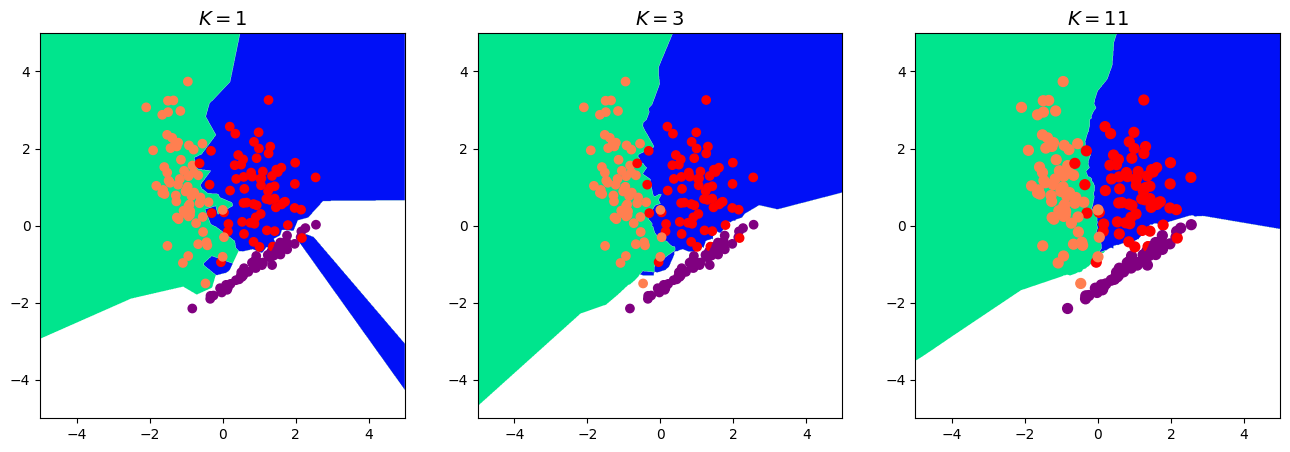

In [3]:
N = 200
D = 2

x, t = make_classification(n_samples=N, 
                            n_features=D, 
                            n_informative=D, 
                            n_redundant=0, 
                            n_repeated=0, 
                            n_classes=3, 
                            n_clusters_per_class=1,
                            random_state=44)
x = jnp.array(x)
t = jnp.array(t)

x_space = jnp.arange(-5, 5, 0.01)
x1, x2 = jnp.meshgrid(x_space, x_space)
x_hat = jnp.vstack((x1.ravel(), x2.ravel())).T

class_colors = []
for i in range(t.shape[0]):
    if t[i] == 0:
        color = "red"
    elif t[i] == 1:
        color = "coral"
    else:
        color = "purple"
    class_colors.append(color)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
model = NearestNeighborsClassifier()
Z, _, _ = model.predict(x, t, x_hat, k=1)
Z = Z.reshape(-1, 1)

plt.contourf(
    x_space, x_space, Z[:, 0].reshape(x1.shape), cmap="winter", levels=np.arange(-0.1, 1.1, 0.05), antialiased=True
)
plt.scatter(x[:, 0], x[:, 1], color=class_colors)
plt.title("$K=1$", fontsize=14)

plt.subplot(1, 3, 2)
model = NearestNeighborsClassifier()
Z, _, _ = model.predict(x, t, x_hat, k=3)
Z = Z.reshape(-1, 1)
plt.contourf(
    x_space, x_space, Z[:, 0].reshape(x1.shape), cmap="winter", levels=np.arange(-0.1, 1.1, 0.05), antialiased=True
)
plt.scatter(x[:, 0], x[:, 1], color=class_colors)
plt.title("$K=3$", fontsize=14)

plt.subplot(1, 3, 3)
model = NearestNeighborsClassifier()
Z, _, _ = model.predict(x, t, x_hat, k=11)
Z = Z.reshape(-1, 1)
plt.contourf(
    x_space, x_space, Z[:, 0].reshape(x1.shape), cmap="winter", levels=np.arange(-0.1, 1.1, 0.05), antialiased=True
)
plt.scatter(x[:, 0], x[:, 1], color=class_colors, s=50)
plt.title("$K=11$", fontsize=14)
